# COMPSCI 715 - Grad Final Project

### Project Title: Detecting Arbitrage Opportunities in S&P 500 Options Using Unsupervised Deep Learning


> ##### Team Members:
> ##### - Divyanshu Verma
> ##### - Shivam Jayeshkumar Mehta


### Project Overview

This code uses an unsupervised deep learning approach with an autoencoder to identify potential arbitrage opportunities in S&P 500 (SPX) options data. The autoencoder learns to detect anomalies based on the reconstruction error.

#### Terminology

##### **1. Autoencoder**
An autoencoder is a type of neural network used for unsupervised learning. It learns to compress data into a lower-dimensional latent space (encoding) and then reconstruct it back to the original dimension. The difference between the original and reconstructed data, known as the *reconstruction error*, can be used to identify anomalies.

##### **2. Reconstruction Error**
Reconstruction error measures the difference between the original input data and the output produced by the autoencoder. A higher reconstruction error indicates that the data point deviates significantly from learned patterns, suggesting an anomaly.

##### **3. Anomaly**
An anomaly is a data point that does not conform to the expected patterns within a dataset. In the context of options trading, anomalies can indicate pricing discrepancies or arbitrage opportunities.

##### **4. Normalization**
Normalization is a preprocessing step that scales numerical data to a specific range, often between 0 and 1. This ensures consistent input for neural networks and improves the stability of training.

##### **5. Early Stopping**
Early stopping is a regularization technique used to prevent overfitting during training. It stops training when the model’s performance on the validation set stops improving for a specified number of epochs.

##### **6. Options Greeks**
Options Greeks are metrics that describe the sensitivity of an option’s price to various factors. These measures help traders understand how different factors affect the value of an option.

###### **Options Greeks Explained:**

- **Delta (Δ)**:
  - **Definition**: Measures the rate of change of an option’s price concerning changes in the price of the underlying asset.
  - **Call Options**: Delta ranges from 0 to 1.
  - **Put Options**: Delta ranges from -1 to 0.
  - **Example**: If a call option has a delta of 0.5, the option's price will increase by $0.50 for every $1.00 increase in the underlying asset.

- **Gamma (Γ)**:
  - **Definition**: Measures the rate of change of delta concerning changes in the price of the underlying asset.
  - **Effect**: Indicates how much delta will change as the underlying asset price moves.
  - **Example**: Higher gamma means delta is more sensitive to changes in the underlying price, common near the option's expiry.

- **Vega (ν)**:
  - **Definition**: Measures the sensitivity of an option’s price to changes in implied volatility.
  - **Effect**: Higher vega means the option's price is more sensitive to volatility changes.
  - **Example**: If vega is 0.10, the option's price increases by $0.10 for every 1% increase in implied volatility.

- **Theta (Θ)**:
  - **Definition**: Measures the rate at which an option’s price declines as time passes (time decay).
  - **Effect**: Options lose value as they approach expiry.
  - **Example**: If theta is -0.05, the option’s price decreases by $0.05 per day.

- **Rho (ρ)**:
  - **Definition**: Measures the sensitivity of an option’s price to changes in interest rates.
  - **Effect**: Higher rho means the option's price is more sensitive to interest rate changes.
  - **Example**: If rho is 0.20, the option's price increases by $0.20 for every 1% increase in interest rates.

##### **7. Implied Volatility (IV)**
Implied volatility represents the market's expectation of future price fluctuations of the underlying asset. Higher implied volatility typically increases an option's premium due to the greater uncertainty.

##### **8. Mean Squared Error (MSE)**
Mean Squared Error is a common loss function for regression tasks. It measures the average of the squared differences between predicted and actual values. In this project, it quantifies the reconstruction error.

##### **9. Back-Testing**
Back-testing involves testing a trading strategy on historical data to evaluate its effectiveness. It helps determine if detected anomalies translate into profitable trading opportunities.

##### **10. Arbitrage**
Arbitrage refers to the practice of exploiting price discrepancies between different markets or instruments to achieve risk-free profit.



## CODE


#### Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error


#### Load and Preprocess Data

In [7]:
# Load dataset
dataset_path = 'spx_05x_202301.csv'
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print("Dataset Sample:\n")
df.head(100)


Dataset Sample:



,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],...,[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1672756210,2023-01-03 09:30,2023-01-03,9.5,3858.67,2023-01-03,1672779600,0.27,1.00000,0.00000,...,0.00,-0.00030,0.00000,0.00467,-0.32536,0.00000,8.591690,,2858.7,0.741
1,1672756210,2023-01-03 09:30,2023-01-03,9.5,3858.67,2023-01-03,1672779600,0.27,1.00000,0.00000,...,0.00,-0.00008,0.00000,0.00071,-0.02462,-0.00011,6.179460,,2658.7,0.689
2,1672756210,2023-01-03 09:30,2023-01-03,9.5,3858.67,2023-01-03,1672779600,0.27,1.00000,0.00000,...,0.00,0.00000,0.00000,0.00098,-0.02548,0.00000,5.383580,,2458.7,0.637
3,1672756210,2023-01-03 09:30,2023-01-03,9.5,3858.67,2023-01-03,1672779600,0.27,1.00000,0.00000,...,0.00,-0.00050,0.00000,0.00690,-0.32563,0.00000,5.690030,,2258.7,0.585
4,1672756210,2023-01-03 09:30,2023-01-03,9.5,3858.67,2023-01-03,1672779600,0.27,0.99708,0.00002,...,0.05,-0.00142,0.00000,0.00743,-0.32554,-0.00046,4.964830,3.000000,2058.7,0.534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1672756210,2023-01-03 09:30,2023-01-03,9.5,3858.67,2023-01-03,1672779600,0.27,0.01072,0.00078,...,102.68,-0.93162,0.00220,0.26108,-1.12084,-0.05447,0.263550,7.000000,81.3,0.021
96,1672756210,2023-01-03 09:30,2023-01-03,9.5,3858.67,2023-01-03,1672779600,0.27,0.00820,0.00062,...,119.12,-0.95159,0.00133,0.19250,-0.42005,-0.03825,0.244320,10.000000,86.3,0.022
97,1672756210,2023-01-03 09:30,2023-01-03,9.5,3858.67,2023-01-03,1672779600,0.27,0.00684,0.00052,...,91.62,-0.93697,0.00178,0.24346,-1.02040,-0.05094,0.284410,6.000000,91.3,0.024
98,1672756210,2023-01-03 09:30,2023-01-03,9.5,3858.67,2023-01-03,1672779600,0.27,0.02189,0.00116,...,100.47,-0.95375,0.00100,0.18531,-0.37011,-0.03568,0.266600,1.000000,96.3,0.025


In [8]:
# Selecting only the numerical columns like strike price, implied volatility, and options prices
columns_to_keep = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]

# Filtering the dataset to keep only relevant numerical features and droping rows with missing values
options_data = df[columns_to_keep].dropna()
print("\nFiltered Columns:\n")
options_data.head()



Filtered Columns:



,[QUOTE_UNIXTIME],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],...,[P_BID],[P_ASK],[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,1672756210,9.5,3858.67,1672779600,0.27,1.00000,0.00000,0.0000,-0.12971,0.02774,...,0.0,0.65,0.00,-0.00030,0.0,0.00467,-0.32536,0.00000,2858.7,0.741
1,1672756210,9.5,3858.67,1672779600,0.27,1.00000,0.00000,0.0000,-0.15621,0.03325,...,0.0,0.05,0.00,-0.00008,0.0,0.00071,-0.02462,-0.00011,2658.7,0.689
2,1672756210,9.5,3858.67,1672779600,0.27,1.00000,0.00000,0.0000,-0.18219,0.03811,...,0.0,0.05,0.00,0.00000,0.0,0.00098,-0.02548,0.00000,2458.7,0.637
3,1672756210,9.5,3858.67,1672779600,0.27,1.00000,0.00000,0.0000,-0.20800,0.04414,...,0.0,0.65,0.00,-0.00050,0.0,0.00690,-0.32563,0.00000,2258.7,0.585
4,1672756210,9.5,3858.67,1672779600,0.27,0.99708,0.00002,0.0172,-1.28041,0.04867,...,0.0,0.65,0.05,-0.00142,0.0,0.00743,-0.32554,-0.00046,2058.7,0.534


In [9]:
# Normalizing the data using Min-Max Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(options_data)

#### Defining Autoencoder Model

In [11]:
# Setting the input dimension to match the number of features
input_dim = scaled_data.shape[1]
encoding_dim = 4  # setting the dimension for the latent space

# Defining the encoder part of the autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Defining the decoder part of the autoencoder
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Combining the encoder and decoder to create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compiling the model using the Adam optimizer and Mean Squared Error (MSE) loss
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,164 (4.55 KB)

 Trainable params: 1,164 (4.55 KB)

 Non-trainable params: 0 (0.00 B)

#### Training Autoencoder

In [13]:
# Splitting the data into training and testing sets
train_size = int(0.8 * len(scaled_data))
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [14]:
# Adding EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',                 # Monitor validation loss for early stopping
    patience=2,                         # Number of epochs to try with no improvement
    restore_best_weights=True           # Restoring the model weights from best epoch before the early stopping
)

In [15]:
# Training model with EarlyStopping
history = autoencoder.fit(train_data, train_data,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(test_data, test_data),
                callbacks=[early_stopping])


Epoch 1/10
298515/298515 ━━━━━━━━━━━━━━━━━━━━ 101s 337us/step - loss: 0.0019 - val_loss: 6.9729e-04
Epoch 2/10
298515/298515 ━━━━━━━━━━━━━━━━━━━━ 100s 336us/step - loss: 5.8951e-04 - val_loss: 7.4501e-04
Epoch 3/10
298515/298515 ━━━━━━━━━━━━━━━━━━━━ 100s 335us/step - loss: 5.5381e-04 - val_loss: 8.0694e-04


#### Anomalies Detection

In [17]:
# Reconstruct the scaled data using the trained autoencoder
reconstructed_data = autoencoder.predict(scaled_data)

# Calculate Mean Squared Error (MSE) between original and reconstructed data
mse = np.mean(np.square(scaled_data - reconstructed_data), axis=1)

# Setting an anomaly threshold at the 95th percentile of the reconstruction errors
threshold = np.percentile(mse, 95)

# Identifying anomalies where the reconstruction error exceeds the threshold
anomalies = mse > threshold

# Add the reconstruction error and anomaly flags to the original dataset
options_data['Reconstruction_Error'] = mse
options_data['Anomaly'] = anomalies

373143/373143 ━━━━━━━━━━━━━━━━━━━━ 58s 156us/step


#### Visualize Results

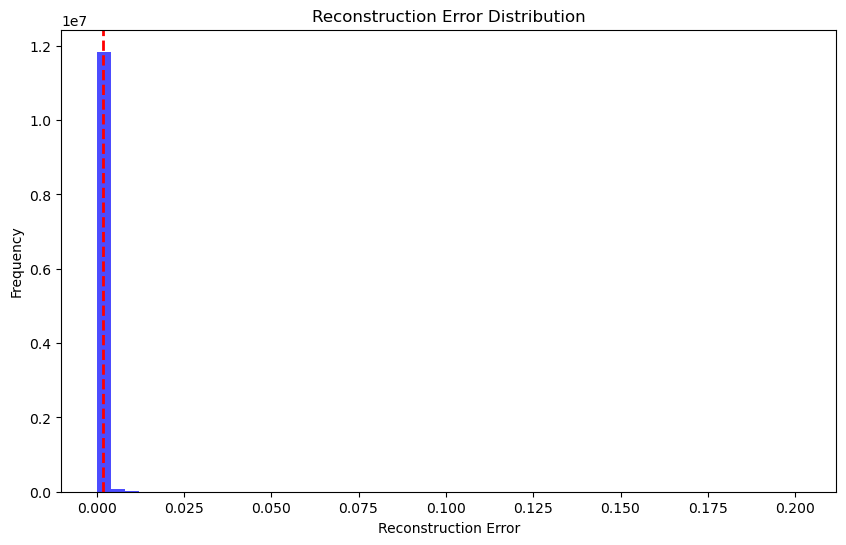

In [19]:
# Plotting the distribution of reconstruction errors with a threshold line
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, color='blue', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2)
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


In [20]:
# Displaying the rows identified as anomalies
anomalous_data = options_data[options_data['Anomaly'] == True]
print("\nIdentified Anomalies:\n")
anomalous_data.head(50)


Identified Anomalies:



,[QUOTE_UNIXTIME],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_UNIX],[DTE],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],...,[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT],Reconstruction_Error,Anomaly
437,1672756210,9.5,3858.67,1673038800,3.27,1.00000,0.0,0.00000,-0.35098,0.29535,...,0.05,-0.00018,0.00000,0.00365,-0.02303,-0.00038,1158.7,0.300,0.004986,True
439,1672756210,9.5,3858.67,1673038800,3.27,1.00000,0.0,0.00000,-0.37047,0.31204,...,0.05,-0.00273,-0.00003,0.03108,-0.26196,-0.00143,1008.7,0.261,0.001907,True
505,1672756210,9.5,3858.67,1673038800,3.27,1.00000,0.0,0.00000,-0.47603,0.40112,...,3.20,-0.03181,0.00065,0.29144,-0.80882,-0.01314,193.7,0.050,0.002118,True
791,1672756210,9.5,3858.67,1673384400,7.27,1.00000,0.0,0.00000,-0.15621,0.26276,...,0.00,-0.00112,0.00000,0.01450,-0.18149,-0.00080,2658.7,0.689,0.014831,True
846,1672756210,9.5,3858.67,1673384400,7.27,1.00000,0.0,0.00000,-0.49136,0.82829,...,28.90,-0.25958,0.00266,1.85238,-2.44923,-0.21967,73.7,0.019,0.002525,True
1051,1672756210,9.5,3858.67,1673557200,9.27,1.00000,0.0,0.00000,-0.25963,0.54726,...,0.17,-0.00093,0.00000,0.02604,-0.14728,-0.00178,1858.7,0.482,0.006042,True
1052,1672756210,9.5,3858.67,1673557200,9.27,1.00000,0.0,0.00000,-0.28594,0.60158,...,0.22,-0.00111,0.00004,0.02996,-0.14596,-0.00117,1658.7,0.430,0.004768,True
1169,1672756210,9.5,3858.67,1673643600,10.27,1.00000,0.0,0.00000,-0.13035,0.30072,...,0.00,-0.00031,0.00000,0.00216,-0.01426,0.00000,2858.7,0.741,0.038230,True
1170,1672756210,9.5,3858.67,1673643600,10.27,1.00000,0.0,0.00000,-0.15579,0.36099,...,0.00,-0.00088,0.00000,0.01654,-0.14127,-0.00066,2658.7,0.689,0.014769,True
1462,1672756210,9.5,3858.67,1674075600,15.27,1.00000,0.0,0.00000,-0.20798,0.69923,...,0.00,-0.00011,0.00000,0.00351,-0.01012,-0.00016,2258.7,0.585,0.009487,True


#### Saving Results For Back-Testing

In [22]:
output_path = 'options_anomalies_detected.csv'
anomalous_data.to_csv(output_path, index=False)
print(f"Anomalous data saved to: {output_path}")

Anomalous data saved to: options_anomalies_detected.csv


#### Back-Testing 

###### Results Using Anomalous Detected data

Initial Capital: $100000
Final Capital: $154595.40
Total Return: $54595.40
Number of Trades: 1000
Average Return per Trade: $54.60
Volatility (Standard Deviation): $92.15
Sharpe Ratio: 0.59
Maximum Drawdown: $373.21


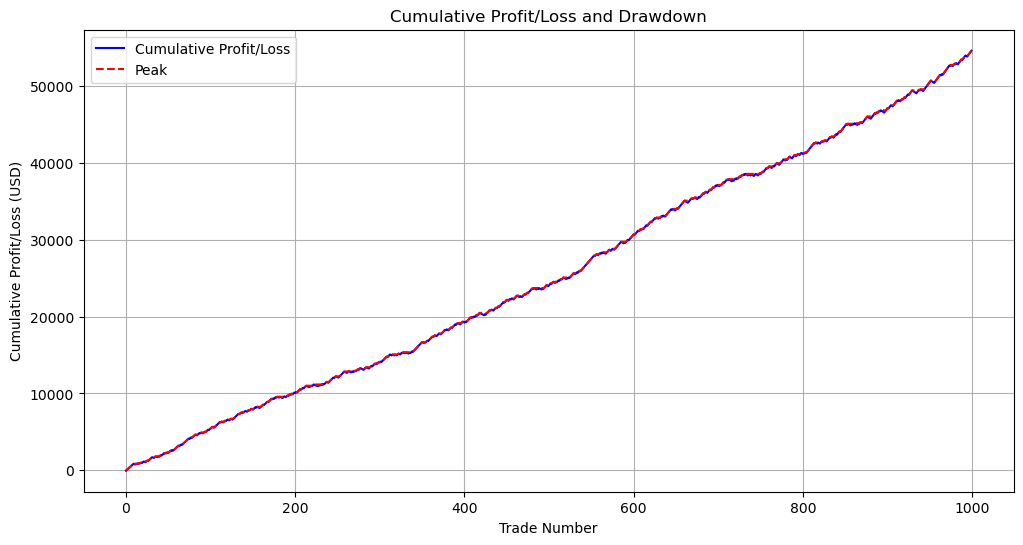

Backtesting results saved to 'backtest_results.csv'


In [38]:


# Parameters
initial_capital = 100000
max_trades = 1000
capital = initial_capital

# Load Anomalies Data
# Use the anomalies detected in the previous autoencoder workflow
file_path = "options_anomalies_detected.csv"  # Anomalies detected in the autoencoder step

data = pd.read_csv(file_path)
data.columns = data.columns.str.strip()

# Ensure the anomaly flag and required columns exist
if "Anomaly" not in data.columns or "[C_DELTA]" not in data.columns:
    raise ValueError("Dataset must contain 'Anomaly' and '[C_DELTA]' columns.")

# Filter anomalies for backtesting
anomalies = data[data['Anomaly'] == True].head(max_trades)  # Limit to max_trades

# Trading Simulation
trade_results = []
for i, (_, row) in enumerate(anomalies.iterrows()):
    if capital < 100:  # Stop if not enough capital
        break
    position_size = capital * 0.01  # Trade 1% of current capital
    call_delta = row['[C_DELTA]']

    # Trade outcome logic
    if call_delta > 0.9:
        outcome = 0.1 if np.random.rand() < 0.7 else -0.05
    else:
        outcome = 0.1 if np.random.rand() < 0.5 else -0.05

    profit_loss = position_size * outcome
    capital += profit_loss
    trade_results.append(profit_loss)

# Backtest Results
total_return = capital - initial_capital
returns = np.array(trade_results)

# Risk Metrics
mean_return = np.mean(returns)
volatility = np.std(returns)
sharpe_ratio = mean_return / volatility if volatility != 0 else 0

# Calculate cumulative returns for Max Drawdown
cumulative_returns = np.cumsum(returns)
peak = np.maximum.accumulate(cumulative_returns)
drawdown = peak - cumulative_returns
max_drawdown = np.max(drawdown)

# Print Results
print(f"Initial Capital: ${initial_capital}")
print(f"Final Capital: ${capital:.2f}")
print(f"Total Return: ${total_return:.2f}")
print(f"Number of Trades: {len(trade_results)}")
print(f"Average Return per Trade: ${mean_return:.2f}")
print(f"Volatility (Standard Deviation): ${volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: ${max_drawdown:.2f}")

# Plot Cumulative Results
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Cumulative Profit/Loss", color="blue")
plt.plot(peak, label="Peak", linestyle="--", color="red")
plt.title("Cumulative Profit/Loss and Drawdown")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Profit/Loss (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Save backtest results to a CSV file
backtest_results = pd.DataFrame({
    "Trade Number": range(1, len(trade_results) + 1),
    "Profit/Loss": trade_results,
    "Cumulative Return": cumulative_returns
})
backtest_results.to_csv("backtest_results.csv", index=False)
print("Backtesting results saved to 'backtest_results.csv'")


###### Results Using Without Anomalous Detected data (using orginal dataset)

Initial Capital: $100000
Final Capital: $147794.47
Total Return: $47794.47
Number of Trades: 1000
Average Return per Trade: $47.79
Volatility (Standard Deviation): $91.42
Sharpe Ratio: 0.52
Maximum Drawdown: $466.17


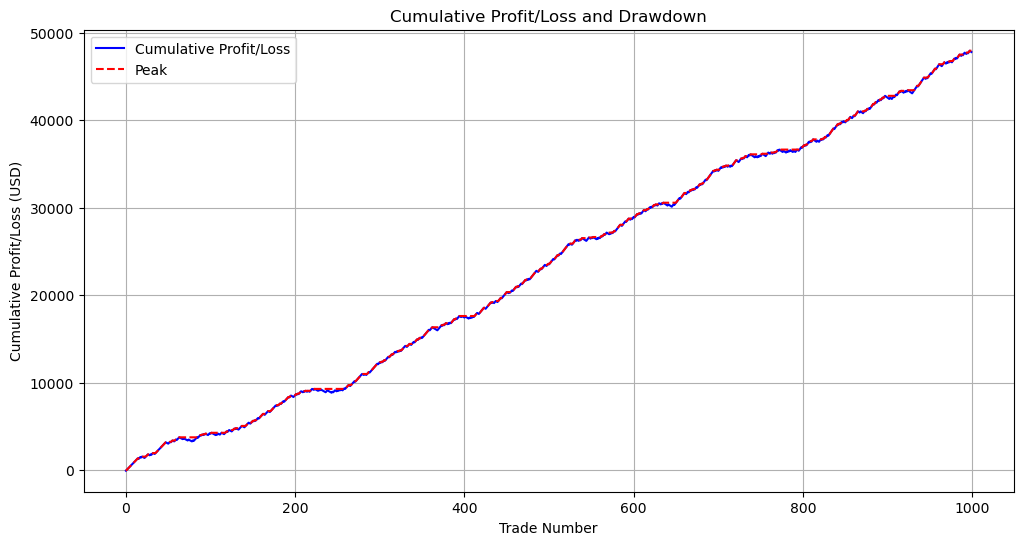

Backtesting results saved to 'backtest_results_original.csv'


In [14]:
# Import required libraries


# Parameters
initial_capital = 100000
max_trades = 1000
capital = initial_capital

# Load Original Dataset
file_path = "spx_05x_202301.csv"  # Original dataset

data = pd.read_csv(file_path)
data.columns = data.columns.str.strip()

# Ensure required columns exist
if "[C_DELTA]" not in data.columns:
    raise ValueError("Dataset must contain '[C_DELTA]' column.")

# Limit trades to max_trades for consistency
original_data = data.head(max_trades)

# Trading Simulation
trade_results = []
for i, (_, row) in enumerate(original_data.iterrows()):
    if capital < 100:  # Stop if not enough capital
        break
    position_size = capital * 0.01  # Trade 1% of current capital
    call_delta = row['[C_DELTA]']

    # Trade outcome logic
    if call_delta > 0.9:
        outcome = 0.1 if np.random.rand() < 0.7 else -0.05
    else:
        outcome = 0.1 if np.random.rand() < 0.5 else -0.05

    profit_loss = position_size * outcome
    capital += profit_loss
    trade_results.append(profit_loss)

# Backtest Results
total_return = capital - initial_capital
returns = np.array(trade_results)

# Risk Metrics
mean_return = np.mean(returns)
volatility = np.std(returns)
sharpe_ratio = mean_return / volatility if volatility != 0 else 0

# Calculate cumulative returns for Max Drawdown
cumulative_returns = np.cumsum(returns)
peak = np.maximum.accumulate(cumulative_returns)
drawdown = peak - cumulative_returns
max_drawdown = np.max(drawdown)

# Print Results
print(f"Initial Capital: ${initial_capital}")
print(f"Final Capital: ${capital:.2f}")
print(f"Total Return: ${total_return:.2f}")
print(f"Number of Trades: {len(trade_results)}")
print(f"Average Return per Trade: ${mean_return:.2f}")
print(f"Volatility (Standard Deviation): ${volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: ${max_drawdown:.2f}")

# Plot Cumulative Results
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="Cumulative Profit/Loss", color="blue")
plt.plot(peak, label="Peak", linestyle="--", color="red")
plt.title("Cumulative Profit/Loss and Drawdown")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Profit/Loss (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Save backtest results to a CSV file
backtest_results = pd.DataFrame({
    "Trade Number": range(1, len(trade_results) + 1),
    "Profit/Loss": trade_results,
    "Cumulative Return": cumulative_returns
})
backtest_results.to_csv("backtest_results_original.csv", index=False)
print("Backtesting results saved to 'backtest_results_original.csv'")
